<a href="https://colab.research.google.com/github/Kwonjihan/ML-teamproject/blob/developtemp/SeongYeomByeon/BERT_pretraining_with_keyword_score_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Attention Score에 Keyword Score를 가중치로 반영]**
- 기존 논문에 기대지 않고 아이디어를 떠올려보기 위한 시도 -> 참고문헌 없음
- 기존 Attention은 모든 토큰에 대해 동일하게 Dot product를 수행
- 물론 학습을 진행할수록 값은 작아지겠지만, 여전히 중요하지 않은 토큰에도 동일한 비중을 두어 Attention Score를 계산함
- 문장마다 중요한 단어, 즉 Keyword가 존재할텐데, 모든 토큰에 동일하게 Dot product를 수행하는 것은 비효율적이지 않을까?
- 일종의 Keyword Score를 구하여, Attention에 일종의 가중치로서 적용
- 키워드 스코어는 어떻게? -> 'CLS토큰' : 문장을 대표하는 일종의 Context vector
- CLS토큰과의 Similarity는 곧 그 토큰(단어)이 문장의 맥락에 얼마나 기여하는지(Keyword Score)를 의미할 것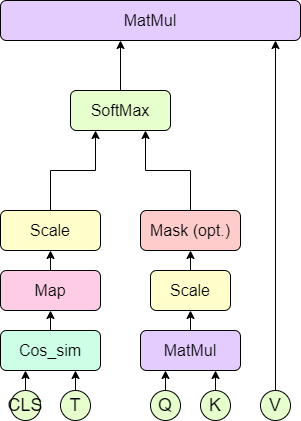

In [1]:
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00


In [8]:
import math
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.optim import AdamW
import random
import torch.optim as optim
from torch.utils.data import RandomSampler, DataLoader, random_split
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, DataCollatorForLanguageModeling
from typing import Optional, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers.modeling_outputs import ModelOutput, MaskedLMOutput

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# activation function 불러오기
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": torch.nn.functional.silu}

In [5]:
class Config:
    vocab_size=30522
    hidden_size=768
    num_hidden_layers=8
    num_attention_heads=12
    intermediate_size=3072
    hidden_act="gelu"
    hidden_dropout_prob=0.1
    attention_probs_dropout_prob=0.1
    max_position_embeddings=512
    type_vocab_size=2
    initializer_range=0.02
    layer_norm_eps=1e-12
    pad_token_id=0
    gradient_checkpointing=False
    position_embedding_type="absolute"
    use_cache=True
    is_decoder = False

# BERT 입력 임베딩 생성 클래스
class BertEmbeddings(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        # 단어 임베딩, 위치 임베딩, 토큰 타입 임베딩
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        # 레이어 정규화와 드롭아웃
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)), persistent=False)
        self.register_buffer("token_type_ids", torch.zeros(self.position_ids.size(), dtype=torch.long), persistent=False)

    def forward(self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length: seq_length + past_key_values_length]

        if token_type_ids is None:
            if hasattr(self, "token_type_ids"):
                buffered_token_type_ids = self.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(input_shape[0], seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # 입력 임베딩 생성
        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

# 셀프 어텐션 구현 클래스
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention heads (%d)" %
                (config.hidden_size, config.num_attention_heads))

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        #################################
        self.keyword_scale = nn.Parameter(torch.ones(1))# 키워드 스코어에 대한 스케일링 파라미터를 학습 가능하도록 추가
        #################################

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        #################################
        # 어텐션 스코어 계산
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # 키워드 스코어 계산
        cls_token = hidden_states[:, 0, :]  # CLS 토큰 추출
        token_similarities = F.cosine_similarity(hidden_states, cls_token.unsqueeze(1).expand_as(hidden_states), dim=-1)  # 각 토큰과 CLS토큰의 cosine similarity 계산
        keyword_scores = (token_similarities + 1) / 2  # 0~1사이로 매핑

        # 어텐션 스코어에 키워드 스코어 반영
        attention_scores = attention_scores * keyword_scores.unsqueeze(1).unsqueeze(1) * self.keyword_scale # 키워드 스코어를 attention score에 곱한 후, 스케일링 파라미터를 적용
        #################################

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
        return outputs

# 셀프 어텐션 출력 처리 클래스
class BertSelfOutput(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

# 어텐션 메커니즘 클래스
class BertAttention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False):
        # 셀프 어텐션 및 출력 계산
        self_outputs = self.self(
            input_tensor,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], input_tensor)
        outputs = (attention_output,) + self_outputs[1:]
        return outputs

# 중간 레이어 활성화 함수 클래스
class BertIntermediate(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = ACT2FN[config.hidden_act]

    def forward(self, hidden_states):
        # 중간 레이어 활성화 함수 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

# 중간 레이어 출력 처리 클래스
class BertOutput(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.Layer

    def forward(self, hidden_states, input_tensor):
        # 드롭아웃, 레이어 정규화, 잔차 연결 적용
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

# 하나의 BERT 레이어를 구현하는 클래스
class BertLayer(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False):
        # 어텐션과 출력 계산
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        layer_output = self.output(self.intermediate(attention_output), attention_output)
        outputs = (layer_output,) + self_attention_outputs[1:]
        return outputs

# 여러 BERT 레이어를 포함하는 인코더 클래스
class BertEncoder(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_values=None, use_cache=None, output_attentions=False, output_hidden_states=False, return_dict=True):
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        for i, layer_module in enumerate(self.layer):
            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(
                hidden_states,
                attention_mask,
                layer_head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                past_key_value,
                output_attentions,
            )
            hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        return (hidden_states, all_hidden_states, all_attentions)

# 첫 번째 토큰의 출력을 풀링하는 클래스
class BertPooler(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # 첫 번째 토큰의 텐서를 사용해 풀링 출력 생성
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

# 전체 BERT 모델을 구현하는 클래스
class BertModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_values=None, use_cache=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        # 입력 텐서의 크기 확인
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("input_ids 혹은 inputs_embeds 둘 중 하나의 형식으로만 입력해야 합니다.")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("input_ids 또는 inputs_embeds의 형식이어야 합니다.")

        device = input_ids.device if input_ids is not None else inputs_embeds.device
        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        extended_attention_mask = attention_mask[:, None, None, :]
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        head_mask = [None] * self.config.num_hidden_layers

        # 임베딩 출력 계산
        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
        )
        # 인코더 출력 계산
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)
        return sequence_output, pooled_output

class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.transform_act_fn = ACT2FN[config.hidden_act]
        self.LayerNorm = nn.LayerNorm(
            config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

class BertLMPredictionHead(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)
        self.decoder = nn.Linear(
            config.hidden_size, config.vocab_size, bias=False)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores

class BertForPreTraining(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.bert = BertModel(config)
        self.cls = BertOnlyMLMHead(config)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        return_dict = return_dict if return_dict is not None else True

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        prediction_scores = self.cls(sequence_output)

        masked_lm_loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

        return MaskedLMOutput(
            loss=masked_lm_loss,
            logits=prediction_scores,
            hidden_states=None,
            attentions=None,
        )

In [6]:
class CSVDataset(Dataset):
    def __init__(self, file_path, tokenizer, block_size=512):
        # 데이터셋 로드
        df = pd.read_csv(file_path)
        text = " ".join(df["text"].tolist())
        self.examples = []

        # 토크나이즈 및 블록 크기로 자르기
        for i in tqdm(range(0, len(text) - block_size, block_size), desc="Tokenizing text"):
            chunk = text[i:i + block_size]
            inputs = tokenizer(chunk, add_special_tokens=True, max_length=block_size, truncation=True, return_tensors="pt", padding="max_length")
            inputs['labels'] = inputs.input_ids.clone()
            self.examples.append(inputs)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return {key: val.squeeze(0) for key, val in self.examples[i].items()}

# 데이터셋 저장 함수
def save_dataset(dataset, file_path):
    torch.save(dataset, file_path)

# 데이터셋 로드 함수
def load_dataset(file_path):
    return torch.load(file_path)

# 메인 함수
def main():
    # 데이터셋 경로 지정
    data_dir = "/content/drive/MyDrive/bookcorpus_reduced.csv"
    file_path = os.path.join(data_dir)
    processed_data_path = os.path.join("/content/drive/MyDrive/processed_dataset.pt")

    # 토크나이저 초기화
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # 데이터셋 전처리 및 저장
    if not os.path.exists(processed_data_path):
        full_dataset = CSVDataset(file_path, tokenizer)
        save_dataset(full_dataset, processed_data_path)
        print("전처리된 데이터셋 저장 완료.")
    else:
        full_dataset = load_dataset(processed_data_path)
        print("전처리된 데이터셋 불러오기 완료.")

    # 데이터셋 분할 (80% train, 10% validation, 10% test)
    train_size = int(0.8 * len(full_dataset))
    val_size = int(0.1 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # 데이터 로더 생성
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=data_collator)
    validation_dataloader = DataLoader(val_dataset, batch_size=8, collate_fn=data_collator)
    test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=data_collator)

    return train_dataloader, validation_dataloader, test_dataloader, tokenizer

train_dataloader, validation_dataloader, test_dataloader, tokenizer = main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

전처리된 데이터셋 불러오기 완료.


In [12]:
def calculate_perplexity(loss):
    return math.exp(loss)

def train(model, train_dataloader, validation_dataloader, tokenizer, device, epochs=3):
    model.train()  # 모델을 학습 모드로 설정
    model.to(device)  # 모델을 지정된 장치로 이동
    optimizer = AdamW(model.parameters(), lr=5e-5)  # 옵티마이저 설정

    # 에포크만큼 반복
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        running_loss = 0.0

        # 데이터 로더에서 미니배치를 하나씩 가져와서 학습
        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            inputs = {key: val.to(device) for key, val in batch.items()}

            outputs = model(**inputs)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 10번째 배치마다 현재 손실과 퍼플렉서티 출력
            if step % 10 == 0 and step != 0:
                current_loss = running_loss / (step + 1)
                current_perplexity = calculate_perplexity(current_loss)
                print(f"Batch {step}, Loss: {current_loss:.4f}, Perplexity: {current_perplexity:.4f}")

        # 에포크의 손실과 퍼플렉서티 출력
        epoch_loss = running_loss / len(train_dataloader)
        epoch_perplexity = calculate_perplexity(epoch_loss)
        print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}, Perplexity: {epoch_perplexity:.4f}")

        # 검증 단계
        model.eval()  # 모델을 평가 모드로 설정
        validation_loss = 0.0

        with torch.no_grad():
            for step, batch in enumerate(tqdm(validation_dataloader, desc="Validating")):
                inputs = {key: val.to(device) for key, val in batch.items()}

                outputs = model(**inputs)
                loss = outputs.loss

                validation_loss += loss.item()

        # 검증 손실과 퍼플렉서티 출력
        epoch_val_loss = validation_loss / len(validation_dataloader)
        epoch_val_perplexity = calculate_perplexity(epoch_val_loss)
        print(f"Validation Loss: {epoch_val_loss:.4f}, Perplexity: {epoch_val_perplexity:.4f}")
        model.train()  # 평가 후에 모델을 다시 학습 모드로 설정

def test(model, test_dataloader, device):
    model.eval()  # 모델을 평가 모드로 설정
    test_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            test_loss += loss.item()

    # 테스트 데이터셋의 퍼플렉서티 출력
    test_loss = test_loss / len(test_dataloader)
    test_perplexity = calculate_perplexity(test_loss)
    print(f"Test Loss: {test_loss:.4f}, Perplexity: {test_perplexity:.4f}")

# 데이터셋과 데이터 로더 설정
# (이 부분은 주어진 코드에서 제공된 데이터 로더를 사용한다고 가정합니다)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForPreTraining(Config)
train(model, train_dataloader, validation_dataloader, tokenizer, device, epochs=3)
test(model, test_dataloader, device)

Epoch 1/3


Training:   4%|▎         | 11/294 [00:08<03:38,  1.29it/s]

Batch 10, Loss: 9.7127, Perplexity: 16526.5302


Training:   7%|▋         | 21/294 [00:16<03:33,  1.28it/s]

Batch 20, Loss: 9.3219, Perplexity: 11180.5230


Training:  11%|█         | 31/294 [00:24<03:27,  1.27it/s]

Batch 30, Loss: 9.1136, Perplexity: 9078.3508


Training:  14%|█▍        | 41/294 [00:32<03:17,  1.28it/s]

Batch 40, Loss: 8.9136, Perplexity: 7432.5041


Training:  17%|█▋        | 51/294 [00:39<03:08,  1.29it/s]

Batch 50, Loss: 8.7287, Perplexity: 6177.4504


Training:  21%|██        | 61/294 [00:47<02:59,  1.30it/s]

Batch 60, Loss: 8.5990, Perplexity: 5426.3790


Training:  24%|██▍       | 71/294 [00:55<02:50,  1.31it/s]

Batch 70, Loss: 8.4608, Perplexity: 4725.8230


Training:  28%|██▊       | 81/294 [01:02<02:43,  1.31it/s]

Batch 80, Loss: 8.3160, Perplexity: 4088.9717


Training:  31%|███       | 91/294 [01:10<02:35,  1.31it/s]

Batch 90, Loss: 8.2082, Perplexity: 3670.7588


Training:  34%|███▍      | 101/294 [01:18<02:28,  1.30it/s]

Batch 100, Loss: 8.1168, Perplexity: 3350.4088


Training:  38%|███▊      | 111/294 [01:25<02:20,  1.30it/s]

Batch 110, Loss: 8.0330, Perplexity: 3080.9211


Training:  41%|████      | 121/294 [01:33<02:13,  1.30it/s]

Batch 120, Loss: 7.9604, Perplexity: 2865.0885


Training:  45%|████▍     | 131/294 [01:41<02:05,  1.29it/s]

Batch 130, Loss: 7.8856, Perplexity: 2658.8147


Training:  48%|████▊     | 141/294 [01:48<01:58,  1.29it/s]

Batch 140, Loss: 7.8233, Perplexity: 2498.1350


Training:  51%|█████▏    | 151/294 [01:56<01:50,  1.29it/s]

Batch 150, Loss: 7.7738, Perplexity: 2377.4441


Training:  55%|█████▍    | 161/294 [02:04<01:42,  1.30it/s]

Batch 160, Loss: 7.7252, Perplexity: 2264.7155


Training:  58%|█████▊    | 171/294 [02:12<01:34,  1.30it/s]

Batch 170, Loss: 7.6838, Perplexity: 2172.8786


Training:  62%|██████▏   | 181/294 [02:19<01:26,  1.30it/s]

Batch 180, Loss: 7.6458, Perplexity: 2091.8565


Training:  65%|██████▍   | 191/294 [02:27<01:19,  1.30it/s]

Batch 190, Loss: 7.6192, Perplexity: 2036.9288


Training:  68%|██████▊   | 201/294 [02:35<01:11,  1.30it/s]

Batch 200, Loss: 7.5857, Perplexity: 1969.8267


Training:  72%|███████▏  | 211/294 [02:42<01:03,  1.30it/s]

Batch 210, Loss: 7.5566, Perplexity: 1913.4093


Training:  75%|███████▌  | 221/294 [02:50<00:56,  1.30it/s]

Batch 220, Loss: 7.5260, Perplexity: 1855.7093


Training:  79%|███████▊  | 231/294 [02:58<00:48,  1.30it/s]

Batch 230, Loss: 7.5030, Perplexity: 1813.5569


Training:  82%|████████▏ | 241/294 [03:05<00:40,  1.30it/s]

Batch 240, Loss: 7.4834, Perplexity: 1778.3073


Training:  85%|████████▌ | 251/294 [03:13<00:33,  1.30it/s]

Batch 250, Loss: 7.4650, Perplexity: 1745.8807


Training:  89%|████████▉ | 261/294 [03:21<00:25,  1.30it/s]

Batch 260, Loss: 7.4448, Perplexity: 1710.8913


Training:  92%|█████████▏| 271/294 [03:29<00:17,  1.30it/s]

Batch 270, Loss: 7.4250, Perplexity: 1677.4508


Training:  96%|█████████▌| 281/294 [03:36<00:10,  1.30it/s]

Batch 280, Loss: 7.4025, Perplexity: 1640.0443


Training:  99%|█████████▉| 291/294 [03:44<00:02,  1.30it/s]

Batch 290, Loss: 7.3837, Perplexity: 1609.5258


Training: 100%|██████████| 294/294 [03:46<00:00,  1.30it/s]


Epoch 1 Loss: 7.3762, Perplexity: 1597.5647


Validating: 100%|██████████| 37/37 [00:09<00:00,  3.89it/s]


Validation Loss: 6.8428, Perplexity: 937.1385
Epoch 2/3


Training:   4%|▎         | 11/294 [00:08<03:37,  1.30it/s]

Batch 10, Loss: 6.8085, Perplexity: 905.4679


Training:   7%|▋         | 21/294 [00:16<03:30,  1.30it/s]

Batch 20, Loss: 6.8022, Perplexity: 899.8308


Training:  11%|█         | 31/294 [00:23<03:22,  1.30it/s]

Batch 30, Loss: 6.8300, Perplexity: 925.2051


Training:  14%|█▍        | 41/294 [00:31<03:14,  1.30it/s]

Batch 40, Loss: 6.8504, Perplexity: 944.2759


Training:  17%|█▋        | 51/294 [00:39<03:07,  1.30it/s]

Batch 50, Loss: 6.8301, Perplexity: 925.2537


Training:  21%|██        | 61/294 [00:46<02:59,  1.30it/s]

Batch 60, Loss: 6.8203, Perplexity: 916.2841


Training:  24%|██▍       | 71/294 [00:54<02:51,  1.30it/s]

Batch 70, Loss: 6.8152, Perplexity: 911.6393


Training:  28%|██▊       | 81/294 [01:02<02:44,  1.30it/s]

Batch 80, Loss: 6.8238, Perplexity: 919.4978


Training:  31%|███       | 91/294 [01:10<02:36,  1.30it/s]

Batch 90, Loss: 6.8091, Perplexity: 906.0302


Training:  34%|███▍      | 101/294 [01:17<02:28,  1.30it/s]

Batch 100, Loss: 6.8044, Perplexity: 901.7823


Training:  38%|███▊      | 111/294 [01:25<02:20,  1.30it/s]

Batch 110, Loss: 6.8040, Perplexity: 901.4224


Training:  41%|████      | 121/294 [01:33<02:13,  1.30it/s]

Batch 120, Loss: 6.7954, Perplexity: 893.6867


Training:  45%|████▍     | 131/294 [01:40<02:05,  1.30it/s]

Batch 130, Loss: 6.7973, Perplexity: 895.4666


Training:  48%|████▊     | 141/294 [01:48<01:58,  1.30it/s]

Batch 140, Loss: 6.7922, Perplexity: 890.8394


Training:  51%|█████▏    | 151/294 [01:56<01:50,  1.30it/s]

Batch 150, Loss: 6.7904, Perplexity: 889.2905


Training:  55%|█████▍    | 161/294 [02:04<01:42,  1.30it/s]

Batch 160, Loss: 6.7876, Perplexity: 886.8200


Training:  58%|█████▊    | 171/294 [02:11<01:34,  1.30it/s]

Batch 170, Loss: 6.7861, Perplexity: 885.4959


Training:  62%|██████▏   | 181/294 [02:19<01:27,  1.30it/s]

Batch 180, Loss: 6.7809, Perplexity: 880.8913


Training:  65%|██████▍   | 191/294 [02:27<01:19,  1.30it/s]

Batch 190, Loss: 6.7800, Perplexity: 880.0265


Training:  68%|██████▊   | 201/294 [02:34<01:11,  1.29it/s]

Batch 200, Loss: 6.7818, Perplexity: 881.6642


Training:  72%|███████▏  | 211/294 [02:42<01:03,  1.30it/s]

Batch 210, Loss: 6.7819, Perplexity: 881.7610


Training:  75%|███████▌  | 221/294 [02:50<00:56,  1.30it/s]

Batch 220, Loss: 6.7798, Perplexity: 879.8991


Training:  79%|███████▊  | 231/294 [02:58<00:48,  1.29it/s]

Batch 230, Loss: 6.7732, Perplexity: 874.0872


Training:  82%|████████▏ | 241/294 [03:05<00:40,  1.30it/s]

Batch 240, Loss: 6.7712, Perplexity: 872.3813


Training:  85%|████████▌ | 251/294 [03:13<00:33,  1.30it/s]

Batch 250, Loss: 6.7673, Perplexity: 868.9833


Training:  89%|████████▉ | 261/294 [03:21<00:25,  1.29it/s]

Batch 260, Loss: 6.7660, Perplexity: 867.8278


Training:  92%|█████████▏| 271/294 [03:28<00:17,  1.29it/s]

Batch 270, Loss: 6.7589, Perplexity: 861.7165


Training:  96%|█████████▌| 281/294 [03:36<00:10,  1.29it/s]

Batch 280, Loss: 6.7582, Perplexity: 861.1199


Training:  99%|█████████▉| 291/294 [03:44<00:02,  1.30it/s]

Batch 290, Loss: 6.7589, Perplexity: 861.7038


Training: 100%|██████████| 294/294 [03:46<00:00,  1.30it/s]


Epoch 2 Loss: 6.7597, Perplexity: 862.3908


Validating: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Validation Loss: 6.7181, Perplexity: 827.2614
Epoch 3/3


Training:   4%|▎         | 11/294 [00:08<03:38,  1.29it/s]

Batch 10, Loss: 6.6190, Perplexity: 749.1797


Training:   7%|▋         | 21/294 [00:16<03:30,  1.30it/s]

Batch 20, Loss: 6.6354, Perplexity: 761.5934


Training:  11%|█         | 31/294 [00:23<03:22,  1.30it/s]

Batch 30, Loss: 6.6414, Perplexity: 766.1797


Training:  14%|█▍        | 41/294 [00:31<03:14,  1.30it/s]

Batch 40, Loss: 6.6618, Perplexity: 781.9748


Training:  17%|█▋        | 51/294 [00:39<03:07,  1.30it/s]

Batch 50, Loss: 6.6407, Perplexity: 765.6078


Training:  21%|██        | 61/294 [00:47<02:59,  1.30it/s]

Batch 60, Loss: 6.6370, Perplexity: 762.8109


Training:  24%|██▍       | 71/294 [00:54<02:51,  1.30it/s]

Batch 70, Loss: 6.6479, Perplexity: 771.1426


Training:  28%|██▊       | 81/294 [01:02<02:44,  1.30it/s]

Batch 80, Loss: 6.6445, Perplexity: 768.5108


Training:  31%|███       | 91/294 [01:10<02:36,  1.30it/s]

Batch 90, Loss: 6.6371, Perplexity: 762.8839


Training:  34%|███▍      | 101/294 [01:17<02:29,  1.29it/s]

Batch 100, Loss: 6.6387, Perplexity: 764.1305


Training:  38%|███▊      | 111/294 [01:25<02:21,  1.30it/s]

Batch 110, Loss: 6.6394, Perplexity: 764.6406


Training:  41%|████      | 121/294 [01:33<02:13,  1.30it/s]

Batch 120, Loss: 6.6353, Perplexity: 761.4884


Training:  45%|████▍     | 131/294 [01:40<02:05,  1.30it/s]

Batch 130, Loss: 6.6262, Perplexity: 754.6250


Training:  48%|████▊     | 141/294 [01:48<01:57,  1.30it/s]

Batch 140, Loss: 6.6254, Perplexity: 753.9719


Training:  51%|█████▏    | 151/294 [01:56<01:50,  1.30it/s]

Batch 150, Loss: 6.6203, Perplexity: 750.1716


Training:  55%|█████▍    | 161/294 [02:04<01:42,  1.30it/s]

Batch 160, Loss: 6.6255, Perplexity: 754.0529


Training:  58%|█████▊    | 171/294 [02:11<01:34,  1.30it/s]

Batch 170, Loss: 6.6262, Perplexity: 754.5746


Training:  62%|██████▏   | 181/294 [02:19<01:27,  1.30it/s]

Batch 180, Loss: 6.6262, Perplexity: 754.5730


Training:  65%|██████▍   | 191/294 [02:27<01:19,  1.30it/s]

Batch 190, Loss: 6.6237, Perplexity: 752.6973


Training:  68%|██████▊   | 201/294 [02:34<01:11,  1.30it/s]

Batch 200, Loss: 6.6196, Perplexity: 749.6296


Training:  72%|███████▏  | 211/294 [02:42<01:03,  1.30it/s]

Batch 210, Loss: 6.6171, Perplexity: 747.7399


Training:  75%|███████▌  | 221/294 [02:50<00:56,  1.30it/s]

Batch 220, Loss: 6.6118, Perplexity: 743.8049


Training:  79%|███████▊  | 231/294 [02:58<00:48,  1.30it/s]

Batch 230, Loss: 6.6102, Perplexity: 742.6453


Training:  82%|████████▏ | 241/294 [03:05<00:40,  1.30it/s]

Batch 240, Loss: 6.6139, Perplexity: 745.3750


Training:  85%|████████▌ | 251/294 [03:13<00:33,  1.30it/s]

Batch 250, Loss: 6.6169, Perplexity: 747.6046


Training:  89%|████████▉ | 261/294 [03:21<00:25,  1.30it/s]

Batch 260, Loss: 6.6209, Perplexity: 750.6103


Training:  92%|█████████▏| 271/294 [03:28<00:17,  1.30it/s]

Batch 270, Loss: 6.6177, Perplexity: 748.2189


Training:  96%|█████████▌| 281/294 [03:36<00:10,  1.29it/s]

Batch 280, Loss: 6.6164, Perplexity: 747.2261


Training:  99%|█████████▉| 291/294 [03:44<00:02,  1.30it/s]

Batch 290, Loss: 6.6156, Perplexity: 746.6482


Training: 100%|██████████| 294/294 [03:46<00:00,  1.30it/s]


Epoch 3 Loss: 6.6143, Perplexity: 745.6898


Validating: 100%|██████████| 37/37 [00:09<00:00,  3.86it/s]


Validation Loss: 6.6887, Perplexity: 803.3142


Testing: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]

Test Loss: 6.6873, Perplexity: 802.1566


In [10]:
def clear_cuda_memory():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

# Example usage
clear_cuda_memory()